# Chat&Shop Exploration

This report explores the current situation of Chat&Shop. Key findings include:
* Daily volume and conversion rate since the time of launch
* 40% of chats *bounced* (have 2 or less inbound messages)
* Chats that went overnight and/or have outbound response time above 30 minutes greatly affect conversion rate
* There are very few spam messages so it might not be worthwhile to automatically filter them yet
* Only 20% of customers return to Chat&Shop; we might want to bring them back more often

## Volume and Conversion Rate

In [27]:
import numpy as np
import pandas as pd
import qgrid
import json
from ipywidgets import interact
import ipywidgets as widgets
from plotnine import *
from mizani.formatters import *
from mizani.breaks import *
import re
import warnings
warnings.filterwarnings('ignore')

#utils
def remove_outliers(df,col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3-q1
    df = df[(df[col] < q3+1.5*iqr)&(df[col] > q1-1.5*iqr)]
    return df.reset_index(drop=True)
def show_chat(chat_id):
    return qgrid.show_grid(all_df[all_df.chat_id==chat_id][['created_at','direction','text']])

chat_df = pd.read_csv('data/chat_df.csv')
all_df = pd.read_csv('data/all_df.csv')
# qgrid.show_grid(chat_df, show_toolbar=True)

In [28]:
chat_df_secret = chat_df[(chat_df.created_date >= '2019-08-15')].copy()
chat_df = chat_df[(chat_df.created_date >= '2019-08-15')&(chat_df.is_secret==0)].reset_index(drop=True)

We collected all {{f'{chat_df.nb_text.sum():,}'}} messages from Chat&Shop from {{chat_df.created_date.min()}} to {{chat_df.created_date.max()}}. It contains {{f'{chat_df.shape[0]:,}'}} chats from {{f'{chat_df.cns_user_id.nunique():,}'}} unique users (we excluded {{f'{round(chat_df_secret.is_secret.mean()*100)}'}}% of total chats where the users came from the counter and not directly to Chat&Shop).

In [29]:
df = pd.DataFrame(chat_df.groupby(['created_date']).chat_id.nunique()).reset_index()
df = df.merge(pd.DataFrame(all_df.groupby('created_date').owner.nunique()).reset_index())
df['chats_per_person'] = df.chat_id / df.owner

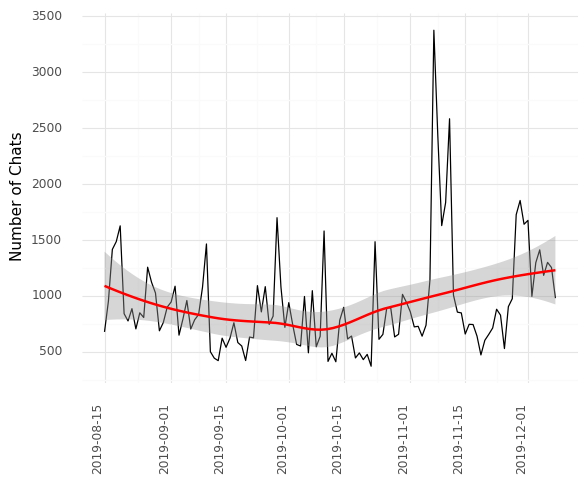

<ggplot: (-9223372036533832097)>

In [30]:
g = (ggplot(df, aes(x='created_date',y='chat_id',group=1)) + geom_line() +
    theme_minimal() + scale_x_date() + ylab('Number of Chats') + xlab('') +
    scale_y_continuous(breaks=[i*500 for i in range(10)])+
    geom_smooth(color='red') +
    theme(axis_text_x = element_text(angle = 90, hjust = 1)))
g

On average, {{f"{round(chat_df.groupby('created_date').owner.nunique().mean())}"}} DAs are on duty every day, meaning a DA takes care of over {{f"{round(df.chats_per_person.mean())}"}} chats a day.

In [31]:
g = (ggplot(df, aes(x='created_date',y='chats_per_person',group=1)) + geom_line() +
    theme_minimal() + scale_x_date() + ylab('Chats per DA') + xlab('') +
    geom_smooth(color='red') + scale_y_continuous(breaks=[i*10 for i in range(20)]) +
    theme(axis_text_x = element_text(angle = 90, hjust = 1)))
g

<ggplot: (307037174)>

Conversion rate hovers around {{f'{round(100*chat_df.opportunity_stage.mean())}'}}% depending on the day.

In [32]:
df = pd.DataFrame(chat_df.groupby(['created_date']).opportunity_stage.mean()).reset_index()
g = (ggplot(df, aes(x='created_date',y='opportunity_stage',group=1)) + geom_line() +
    theme_minimal() + scale_x_date() + ylab('Conversion Rate') + xlab('') +
    scale_y_continuous(labels=percent_format()) +
    geom_smooth(color='red') +
    theme(axis_text_x = element_text(angle = 90, hjust = 1)))
g

<ggplot: (307032987)>

The average minutes spent per chat has steadily declined over time, but we can see each chat takes a lot of time in total and on average between messages.

In [33]:
df = pd.DataFrame(chat_df.groupby(['created_date']).total_mins.mean()).reset_index()
g = (ggplot(df, aes(x='created_date',y='total_mins',group=1)) + geom_line() +
    theme_minimal() + scale_x_date() + ylab('Total Time in Minutes') + xlab('') +
    geom_smooth(color='red') + scale_y_continuous(breaks=[i*500 for i in range(100)]) +
    theme(axis_text_x = element_text(angle = 90, hjust = 1)))
g

<ggplot: (319810957)>

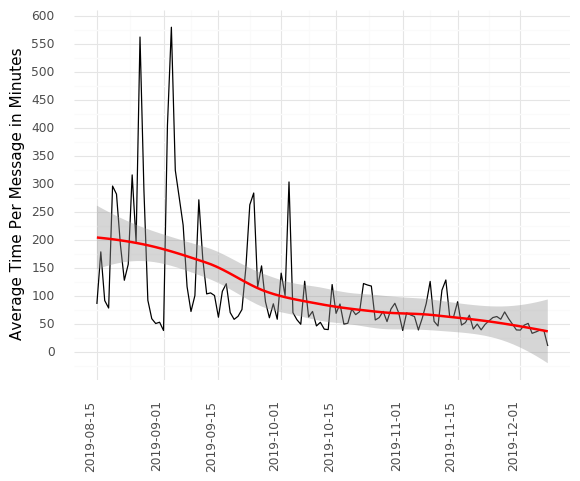

<ggplot: (319817704)>

In [34]:
df = pd.DataFrame(chat_df.groupby(['created_date']).avg_mins.mean()).reset_index()
g = (ggplot(df, aes(x='created_date',y='avg_mins',group=1)) + geom_line() +
    theme_minimal() + scale_x_date() + ylab('Average Time Per Message in Minutes') + xlab('') +
    geom_smooth(color='red') + scale_y_continuous(breaks=[i*50 for i in range(20)]) + 
    theme(axis_text_x = element_text(angle = 90, hjust = 1)))
g

## Bounce Chats

In [35]:
chat_df['bounce_flag'] = chat_df.nb_inbound.map(lambda x: 1 if x<=2 else 0)

We define chats with **only 2 inbound messages or less** as bounced chats. There are {{f'{chat_df.bounce_flag.sum():,}'}} chats ({{f'{round(100*chat_df.bounce_flag.mean())}'}}% of total) by this definition and they almost never convert.

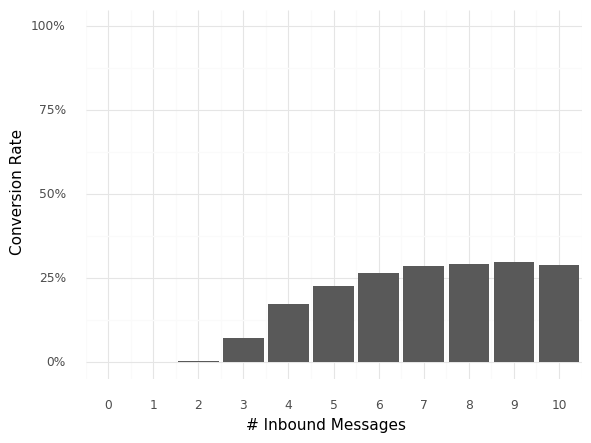

<ggplot: (-9223372036534958122)>

In [36]:
df = pd.DataFrame(chat_df.groupby(['nb_inbound']).opportunity_stage.mean()).reset_index()
g = (ggplot(df, aes(x='nb_inbound',y='opportunity_stage')) + geom_col() +
    theme_minimal() + coord_cartesian(xlim=(0,10)) +
    scale_y_continuous(labels=percent_format())+ xlab('# Inbound Messages') +
    ylab('Conversion Rate') +
    scale_x_continuous(breaks=[i for i in range(11)]))
g

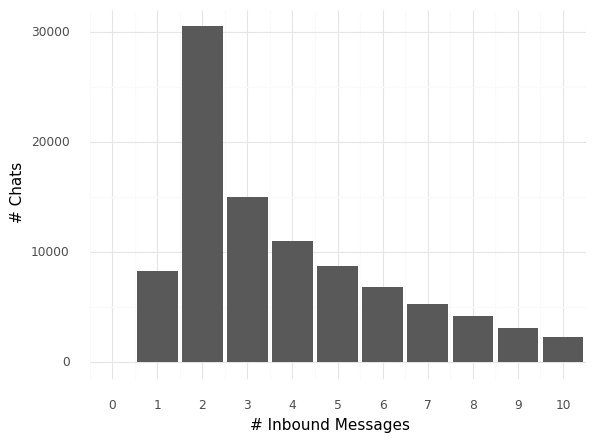

<ggplot: (-9223372036547711260)>

In [37]:
df = pd.DataFrame(chat_df.groupby(['nb_inbound']).opportunity_stage.count()).reset_index()
g = (ggplot(df, aes(x='nb_inbound',y='opportunity_stage')) + geom_col() +
    theme_minimal() + coord_cartesian(xlim=(0,10)) +
    xlab('# Inbound Messages') +
    ylab('# Chats') +
    scale_x_continuous(breaks=[i for i in range(11)]))
g

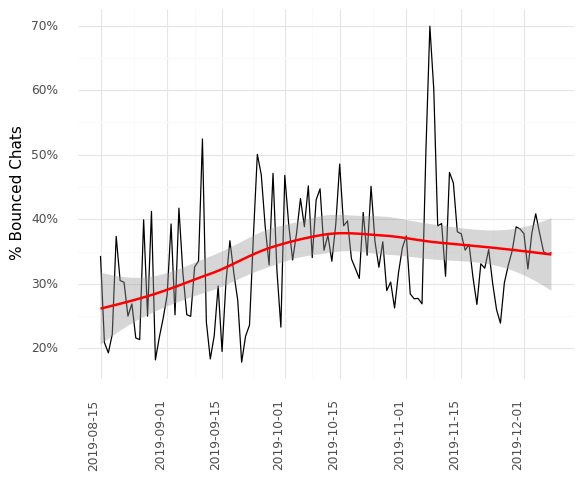

<ggplot: (-9223372036534958178)>

In [38]:
df = pd.DataFrame(chat_df.groupby(['created_date']).bounce_flag.mean()).reset_index()
g = (ggplot(df, aes(x='created_date',y='bounce_flag',group=1)) + geom_line() +
    theme_minimal() + scale_x_date() + ylab('% Bounced Chats') + xlab('') +
    scale_y_continuous(labels=percent_format()) + geom_smooth(color='red') +
    theme(axis_text_x = element_text(angle = 90, hjust = 1)))
g

In [39]:
chat_df = chat_df[chat_df.bounce_flag==0]

## Overnight Chats

In fact, a sizeable number of chats went overnight. This affects conversion rate directly.

In [40]:
df = pd.DataFrame(chat_df.groupby(['created_date']).date_switched.mean()).reset_index()
g = (ggplot(df, aes(x='created_date',y='date_switched',group=1)) + geom_line() +
    theme_minimal() + scale_x_date() + ylab('% Chats That Went Overnight') + xlab('') +
    scale_y_continuous(labels=percent_format()) + geom_smooth(color='red') +
    theme(axis_text_x = element_text(angle = 90, hjust = 1)))
g

<ggplot: (-9223372036536118377)>

In [41]:
df = pd.DataFrame(chat_df.groupby(['date_switched']).opportunity_stage.mean()).reset_index()
g = (ggplot(df, aes(x='factor(date_switched)',y='opportunity_stage')) + geom_col() +
     xlab('Chat Went Overnight')+ ylab('Conversion Rate') +
     scale_y_continuous(labels=percent_format()) +
     geom_text(aes(x='factor(date_switched)',y='opportunity_stage+0.01',label='round(100*opportunity_stage)')) +
     theme_minimal())
g

<ggplot: (-9223372036534961597)>

## Outbound Response Time

Another factor that can affect conversion rate is the average outbound response time. We can assume that the longer a customer has to wait, the less likely they are to buy.

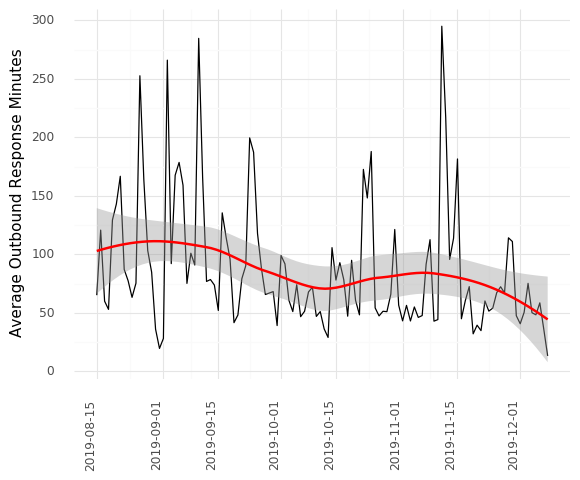

<ggplot: (-9223372036549092990)>

In [42]:
df = pd.DataFrame(chat_df.groupby(['created_date']).outbound_timediff.mean()).reset_index()
g = (ggplot(df, aes(x='created_date',y='outbound_timediff',group=1)) + geom_line() +
    theme_minimal() + scale_x_date() + ylab('Average Outbound Response Minutes') + xlab('') +
    geom_smooth(color='red') + scale_y_continuous(breaks=[i*50 for i in range(20)]) + 
    theme(axis_text_x = element_text(angle = 90, hjust = 1)))
g

We can see that if the chat stays intraday, outbound response time averages around {{round(chat_df.outbound_timediff_intraday.mean())}} minutes.

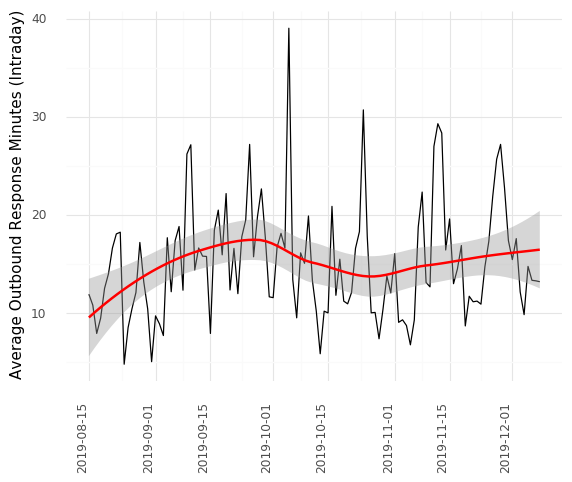

<ggplot: (-9223372036545959701)>

In [43]:
df = pd.DataFrame(chat_df.groupby(['created_date']).outbound_timediff_intraday.mean()).reset_index()
g = (ggplot(df, aes(x='created_date',y='outbound_timediff_intraday',group=1)) + geom_line() +
    theme_minimal() + scale_x_date() + ylab('Average Outbound Response Minutes (Intraday)') + xlab('') +
    geom_smooth(color='red') + 
    theme(axis_text_x = element_text(angle = 90, hjust = 1)))
g

In [44]:
def hour_cut(x):
    if x<30:
        return '0 - less than 30 mins'
    elif (x>=30) & (x<60):
        return '1 - 30-60 mins'
    elif (x>=60) & (x<90):
        return '2 - 60-90 mins'
    elif x>=90:
        return '3 - more than 90 mins'
    else:
        'invalid'
chat_df2 = chat_df[~chat_df.outbound_timediff_intraday.isna()].copy()
chat_df2['outbound_cut'] = chat_df2.outbound_timediff_intraday.map(hour_cut)
nb_over = (chat_df2.outbound_timediff_intraday>=30).sum()
per_over = (chat_df2.outbound_timediff_intraday>=30).mean()

Average outbound response time per chat above 30 minutes severely affects conversion rate. Out of the total {{f'{chat_df2.shape[0]:,}'}} non-bounce chats, {{f'{nb_over:,}'}} chats ({{f'{round(100*per_over):,}'}}%) have average outbound response time of over 30 minutes.

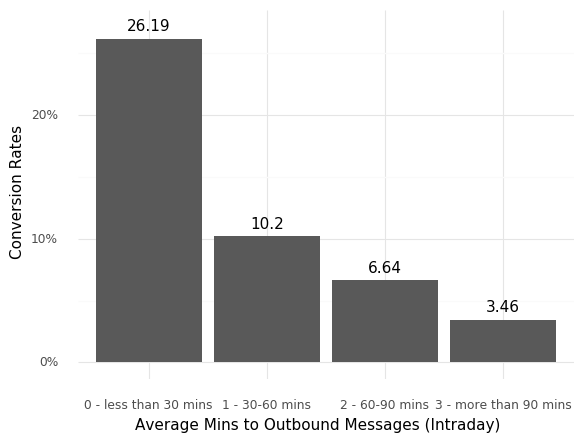

<ggplot: (-9223372036549078349)>

In [45]:
df = pd.DataFrame(chat_df2.groupby('outbound_cut').opportunity_stage.mean()).reset_index()
g = (ggplot(df, aes(x='outbound_cut',y='opportunity_stage')) + geom_col() +
     xlab('Average Mins to Outbound Messages (Intraday)')+ ylab('Conversion Rates') +
     scale_y_continuous(labels=percent_format()) +
     geom_text(aes(x='outbound_cut',y='opportunity_stage+0.01', label='round(100*opportunity_stage,2)')) +
     theme_minimal())
g

## Returning Customers

In [48]:
df = pd.DataFrame(chat_df.groupby('cns_user_id').chat_id.nunique().value_counts()).reset_index()
df.columns = ['nb_chats','nb_users']
df['per_users'] = df.nb_users / df.nb_users.sum()

{{round(100*df.per_users[0],2)}}% of customers only used Chat&Shop once. We might be able to find a strategy to get them to use it again.

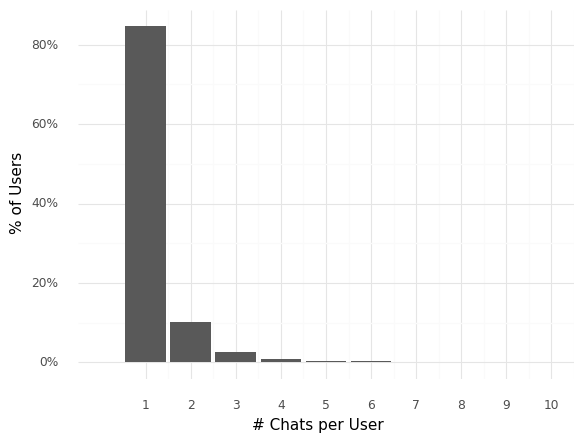

<ggplot: (-9223372036546127167)>

In [49]:
g = (ggplot(df, aes(x='nb_chats',y='per_users')) +
     geom_col() + theme_minimal() + coord_cartesian(xlim=(0,10)) +
     scale_y_continuous(labels=percent_format()) + 
     scale_x_continuous(breaks=df.nb_chats) +
     xlab('# Chats per User') + ylab('% of Users')
    )  
g

## Look for Spams

We look for spams from inbound messages belonging to `Trash Queue`. It turns out that there are very few spam messages and thus might not be worthwhile to do automated spam filtering at this time.

In [55]:
text_df = pd.DataFrame(all_df[(all_df.direction=='inbound')&(all_df.owner=='Trash Queue')].text.value_counts()).reset_index()
text_df.columns = ['text','nb_text']
text_df['nchar'] = text_df.text.map(lambda x: len(str(x)))
text_df = text_df[text_df.nb_text>5]
qgrid.show_grid(text_df, show_toolbar=True)
# text_df.head(50)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Appendix

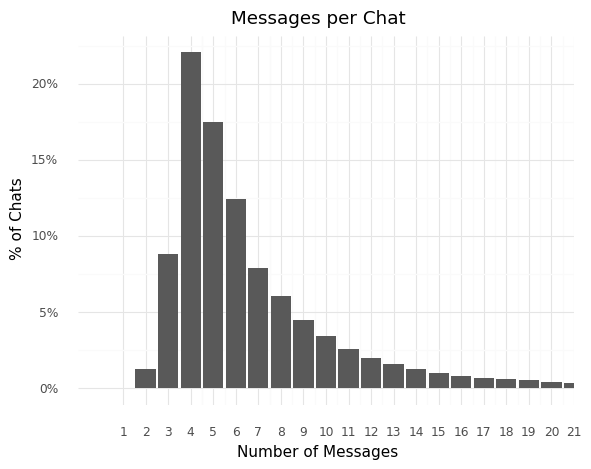

<ggplot: (307923499)>

In [51]:
df = pd.DataFrame(all_df.groupby('chat_id').text.count().value_counts()).reset_index()
df.columns = ['nb_chats','nb_users']
df['per_users'] = df.nb_users / df.nb_users.sum()

g = (ggplot(df, aes(x='nb_chats',y='per_users')) +
     geom_col() + theme_minimal() + coord_cartesian(xlim=(0,20)) +
     scale_y_continuous(labels=percent_format()) + 
     scale_x_continuous(breaks=df.nb_chats) +
     xlab('Number of Messages') + ylab('% of Chats') +
     ggtitle('Messages per Chat')
    )  
g

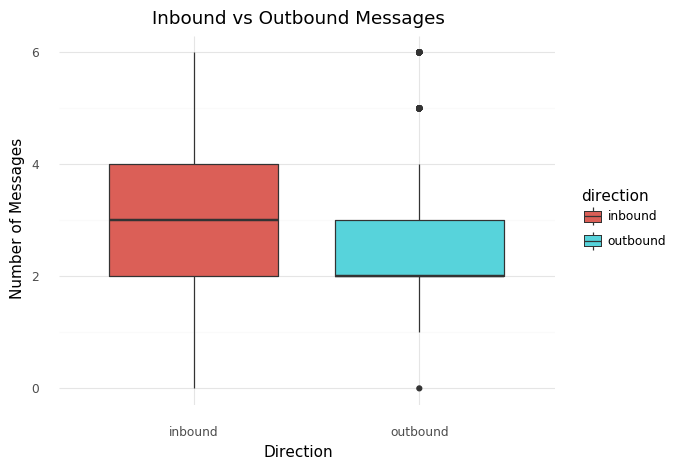

<ggplot: (312316413)>

In [52]:
df = all_df.groupby(['chat_id','direction']).text.count().reset_index()[['direction','text']]
df = df[df.direction!='internal']

def remove_outliers(df,col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3-q1
    df = df[(df[col] < q3+1.5*iqr)&(df[col] > q1-1.5*iqr)]
    return df.reset_index(drop=True)

df = remove_outliers(df,'text')
g = (ggplot(df,aes(x='direction',y='text', fill='direction')) + geom_boxplot(outlier_shape=None) +
     theme_minimal() + ggtitle('Inbound vs Outbound Messages') +
     xlab('Direction') + ylab('Number of Messages')
)
g

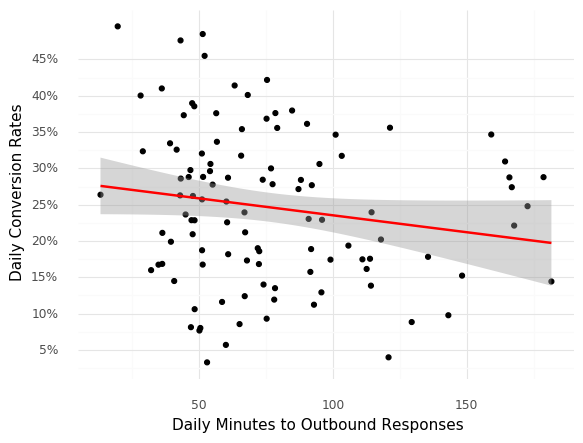

<ggplot: (311181779)>

In [53]:
df = chat_df.groupby('created_date')[['outbound_timediff','opportunity_stage']].mean()
df = remove_outliers(df,'outbound_timediff')
g = (ggplot(df, aes(x='outbound_timediff',y='opportunity_stage')) + geom_point() + 
     stat_smooth(method='lm',color='red') + theme_minimal() + 
     scale_y_continuous(labels=percent_format(), breaks=[5*i/100 for i in range(10)]) +
     xlab('Daily Minutes to Outbound Responses') + ylab('Daily Conversion Rates')
    )
g

In [54]:
df = chat_df.groupby('created_date')[['outbound_timediff_intraday','opportunity_stage']].mean()
df = remove_outliers(df,'outbound_timediff_intraday')
g = (ggplot(df, aes(x='outbound_timediff_intraday',y='opportunity_stage')) + geom_point() + 
     stat_smooth(method='lm',color='red') + theme_minimal() + 
     scale_y_continuous(labels=percent_format(), breaks=[5*i/100 for i in range(10)]) +
     xlab('Daily Minutes to Outbound Responses') + ylab('Daily Conversion Rates')
    )
g

<ggplot: (-9223372036486694200)>